In [44]:
import os

subj = "Subj3"
exp = "exp_no_ear_electrodes"
print_obj = 29
os.makedirs(f"{subj}/{exp}", exist_ok = True)

### Imports

In [45]:
%load_ext autoreload
%autoreload 2

import warnings
import collections
warnings.filterwarnings("ignore")

import mne
import tqdm
import scipy
import numpy
import pandas
import scipy.stats
import gtda.curves
import tqdm.contrib
import gtda.plotting
import gtda.homology
import gtda.diagrams
import gtda.time_series
import sklearn.preprocessing
import sklearn.decomposition
import tqdm.contrib.itertools
pandas.options.display.float_format = '{:,.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
FILTERING_PERCENTILE = 10

CHANNEL_STRIDE = 3
CHANNEL_MAX_TIME_DELAY = 20
CHANNEL_MAX_DIMENSION = 20
CHANNEL_HOMOLOGY_DIMENSIONS = [ 1, 2 ]
CHANNEL_READ_EMBEDDER_PARAMS_FROM_DISK = False

DISSIM_DIMENSION = 50
DISSIM_TIME_DELAY = 1
DISSIM_STRIDE = 20
DISSIM_HOMOLOGY_DIMENSIONS = [ 1, 2, 3, 4, 5 ]

OVERALL_DIMENSION = 5
OVERALL_TIME_DELAY = 11
OVERALL_STRIDE = 3
OVERALL_HOMOLOGY_DIMENSIONS = [ 1, 2, 3 ]

SILHOUETTE_POWERS = [ 1, 2 ]
AMPLITUDE_METRICS = [
    { "id": "bottleneck", "metric": "bottleneck", "metric_params": { } },

    { "id": "wasserstein-1", "metric": "wasserstein", "metric_params": { "p": 1 } },
    { "id": "wasserstein-2", "metric": "wasserstein", "metric_params": { "p": 2 } },

    { "id": "betti-1", "metric": "betti", "metric_params": { "p": 1, 'n_bins': -1 } },
    { "id": "betti-2", "metric": "betti", "metric_params": { "p": 2, 'n_bins': -1 } },
    
    { "id": "landscape-1-1", "metric": "landscape", "metric_params": { "p": 1, "n_layers": 1, 'n_bins': -1 } },
    { "id": "landscape-1-2", "metric": "landscape", "metric_params": { "p": 1, "n_layers": 2, 'n_bins': -1 } },
    { "id": "landscape-2-1", "metric": "landscape", "metric_params": { "p": 2, "n_layers": 1, 'n_bins': -1 } },
    { "id": "landscape-2-2", "metric": "landscape", "metric_params": { "p": 2, "n_layers": 2, 'n_bins': -1 } },

    { "id": "silhouette-1-1", "metric": "silhouette", "metric_params": { "p": 1, "power": 1, 'n_bins': -1 } },
    { "id": "silhouette-1-2", "metric": "silhouette", "metric_params": { "p": 1, "power": 2, 'n_bins': -1 } },
    { "id": "silhouette-2-1", "metric": "silhouette", "metric_params": { "p": 2, "power": 1, 'n_bins': -1 } },
    { "id": "silhouette-2-2", "metric": "silhouette", "metric_params": { "p": 2, "power": 2, 'n_bins': -1 } }
]

In [47]:
class FeatureCalculator:
    def determine_filtering_epsilon(self, diagram):
        life = (diagram[:, :, 1] - diagram[:, :, 0]).flatten()
        life = life[life != 0]
        return numpy.percentile(life, FILTERING_PERCENTILE)
    
    def apply_filtering(self, diagrams):
        eps = self.determine_filtering_epsilon(diagrams)
        self.filtering = gtda.diagrams.Filtering(epsilon = eps)
        return self.filtering.fit_transform(diagrams)
    

    def calc_bins(self, diagrams: numpy.ndarray):
        return 100


    def calc_stats(self, data: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        assert len(data.shape) == 1
        if data.shape == (0,): data = numpy.array([ 0 ])
        stats = numpy.array([
            numpy.max(data), numpy.mean(data), numpy.std(data), numpy.sum(data),
            numpy.percentile(data, 25), numpy.median(data), numpy.percentile(data, 75),
            scipy.stats.kurtosis(data), scipy.stats.skew(data), numpy.linalg.norm(data, ord = 1), numpy.linalg.norm(data, ord = 2)
        ])
        names = [ "max", "mean", "std", "sum", "percentile-25", "median", "percentile-75", "kurtosis", "skew", "norm-1", "norm-2" ]
        return pandas.DataFrame([ numpy.nan_to_num(stats) ], columns = [ f"{prefix} {name}" for name in names ])

    def calc_batch_stats(self, data: numpy.ndarray, homology_dimensions: numpy.ndarray, prefix: str = ""):
        features = [ ]
        for batch in tqdm.tqdm(data, desc = prefix):
            features.append([ ])
            for dim, vec in zip(homology_dimensions, batch):
                features[-1].append(self.calc_stats(vec, prefix = f'{prefix} dim-{dim}'))
            features[-1] = pandas.concat(features[-1], axis = 1)
        return pandas.concat(features, axis = 0)


    def calc_betti_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        self.betti_curve = gtda.diagrams.BettiCurve(n_bins = self.calc_bins(diagrams))
        self.betti_derivative = gtda.curves.Derivative()
        betti_curves = self.betti_curve.fit_transform(diagrams)
        betti_curves = self.betti_derivative.fit_transform(betti_curves)
        return self.calc_batch_stats(betti_curves, self.betti_curve.homology_dimensions_, f'{prefix} betti')

    def calc_landscape_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        self.persistence_landscape = gtda.diagrams.PersistenceLandscape(n_layers = 1, n_bins = self.calc_bins(diagrams))
        persistence_landscape = self.persistence_landscape.fit_transform(diagrams)
        return self.calc_batch_stats(persistence_landscape, self.persistence_landscape.homology_dimensions_, f'{prefix} landscape')

    def calc_silhouette_features(self, diagrams: numpy.ndarray, prefix: str = "", powers: int = SILHOUETTE_POWERS) -> pandas.DataFrame:
        if isinstance(powers, int):
            silhouette = gtda.diagrams.Silhouette(power = powers, n_bins = self.calc_bins(diagrams))
            self.silhouettes.append(silhouette)
            silhouettes = silhouette.fit_transform(diagrams)
            return self.calc_batch_stats(silhouettes, silhouette.homology_dimensions_, f'{prefix} silhouette-{powers}')
        else:
            features = [ ]
            self.silhouettes = [ ]
            for power in powers:
                features.append(self.calc_silhouette_features(diagrams, prefix, power))
            return pandas.concat(features, axis = 1)
    

    def calc_entropy_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        self.entropy = gtda.diagrams.PersistenceEntropy(normalize = True, nan_fill_value = 0)
        features = self.entropy.fit_transform(diagrams)
        names = [ f'{prefix} entropy dim-{dim}' for dim in self.entropy.homology_dimensions_ ]
        return pandas.DataFrame(features, columns = names)
    
    def calc_number_of_points_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        self.number_of_points = gtda.diagrams.NumberOfPoints()
        features = self.number_of_points.fit_transform(diagrams)
        names = [ f'{prefix} numberofpoints dim-{dim}' for dim in self.number_of_points.homology_dimensions_ ]
        return pandas.DataFrame(features, columns = names)
    
    def calc_amplitude_features(self, diagrams: numpy.ndarray, prefix: str = "", **metric) -> pandas.DataFrame:
        if len(metric) == 0:
            features = [ ]
            self.amplitudes = [ ]
            for metric in tqdm.tqdm(AMPLITUDE_METRICS, desc = f'{prefix} amplitudes'):
                features.append(self.calc_amplitude_features(diagrams, prefix, **metric))
            return pandas.concat(features, axis = 1)
        else:
            metric_params = metric['metric_params'].copy()
            if metric_params.get('n_bins', None) == -1:
                metric_params['n_bins'] = self.calc_bins(diagrams)
            amplitude = gtda.diagrams.Amplitude(metric = metric['metric'], metric_params = metric_params)
            self.amplitudes.append(amplitude)
            features = amplitude.fit_transform(diagrams)
            return pandas.concat([
                pandas.DataFrame(features, columns = [ f'{prefix} amplitude-{metric["id"]} dim-{dim}' for dim in amplitude.homology_dimensions_ ]),
                pandas.DataFrame(numpy.linalg.norm(features, axis = 1, ord = 1).reshape(-1, 1), columns = [ f'{prefix} amplitude-{metric["id"]} norm-1' ]),
                pandas.DataFrame(numpy.linalg.norm(features, axis = 1, ord = 2).reshape(-1, 1), columns = [ f'{prefix} amplitude-{metric["id"]} norm-2' ])
            ], axis = 1)
    
    def calc_lifetime_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        if len(diagrams.shape) == 3:
            features = [ ]
            for diag in tqdm.tqdm(diagrams, desc = f'{prefix} lifetime'):
                features.append(self.calc_lifetime_features(diag, prefix))
            return pandas.concat(features, axis = 0)

        birth, death, dim = diagrams[:, 0], diagrams[:, 1], diagrams[:, 2]
        life = death - birth
        
        eps = self.filtering.epsilon
        birth, death, dim = birth[life >= eps], death[life >= eps], dim[life >= eps]
        bd2 = (birth + death) / 2.0
        life = death - birth

        bd2_features = [ self.calc_stats(bd2, f'{prefix} bd2 all') ]
        life_features = [ self.calc_stats(life, f'{prefix} life all') ]
        for d in numpy.unique(diagrams[:, 2]).astype(int):
            bd2_features.append(self.calc_stats(bd2[dim == d], f'{prefix} bd2 dim-{d}'))
            life_features.append(self.calc_stats(life[dim == d], f'{prefix} life dim-{d}'))
        return pandas.concat([ *life_features, *bd2_features ], axis = 1)
        

    def calc_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        diagrams = self.apply_filtering(diagrams)
        print('Filtered diagrams:', diagrams.shape)
        print('N bins:', self.calc_bins(diagrams))
        return pandas.concat([
           self.calc_betti_features           (diagrams, prefix).reset_index(drop = True),
           self.calc_landscape_features       (diagrams, prefix).reset_index(drop = True),
           self.calc_silhouette_features      (diagrams, prefix).reset_index(drop = True),
           self.calc_entropy_features         (diagrams, prefix).reset_index(drop = True),
           self.calc_number_of_points_features(diagrams, prefix).reset_index(drop = True),
           self.calc_amplitude_features       (diagrams, prefix).reset_index(drop = True),
           self.calc_lifetime_features        (diagrams, prefix).reset_index(drop = True)
        ], axis = 1)


    def pca(self, features: numpy.ndarray, scale = False, n_comp = 0.7, var_limit = None, random_state = 42) -> numpy.ndarray:
        if scale:
            features = sklearn.preprocessing.StandardScaler().fit_transform(features)

        if var_limit is not None:
            pca = sklearn.decomposition.PCA(svd_solver = "full", random_state = random_state).fit(features)
            n_comp = (pca.explained_variance_ratio_ >= var_limit).sum()

        pca = sklearn.decomposition.PCA(n_components = n_comp, svd_solver = "full", random_state = random_state)
        features = pca.fit_transform(features)

        log = (
            f'Components: {n_comp}\n'
            f'Explained variance: {round(pca.explained_variance_ratio_.sum(), 2)}\n'
            f'{[ round(x, 3) for x in pca.explained_variance_ratio_ ]}'
        )
        print(log)
        return features, log

### Data

Reading d:\HSE\year-3\HSE\CourseProject\Subj3\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1180 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


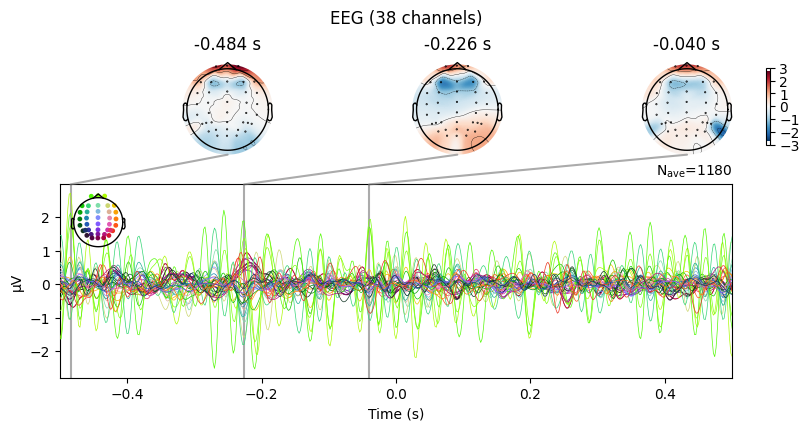

In [48]:
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif").drop_channels(ch_names = [ "A1", "A2" ])
epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)

### Per-channel features

#### TakensEmbedding

In [49]:
if CHANNEL_READ_EMBEDDER_PARAMS_FROM_DISK:
    channel_embedders_params = [ ]
    for params_data in numpy.load(f"{subj}/{exp}/channel_embedders_params.npy"):
        channel_embedders_params.append(list(map(tuple, params_data)))
else:
    channel_searcher = gtda.time_series.SingleTakensEmbedding(
        parameters_type = 'search',
        time_delay = CHANNEL_MAX_TIME_DELAY,
        dimension = CHANNEL_MAX_DIMENSION,
        stride = CHANNEL_STRIDE,
        n_jobs = -1
    )
    channel_embedders_params = [ [ ] for _ in range(data.shape[1]) ]
    for i, j in tqdm.contrib.itertools.product(range(data.shape[0]), range(data.shape[1])):
        channel_searcher.fit(data[i, j, :])
        channel_embedders_params[j].append((channel_searcher.dimension_, channel_searcher.time_delay_))
    numpy.save(f"{subj}/{exp}/channel_embedders_params.npy", channel_embedders_params)

print(len(channel_embedders_params))
print(len(channel_embedders_params[0]))

  0%|          | 0/44840 [00:00<?, ?it/s]

38
1180


In [50]:
channel_embedders = [ ]
for i in range(len(channel_embedders_params)):
    (dimension, time_delay), _ = collections.Counter(channel_embedders_params[i]).most_common(1)[0]
    attractor = gtda.time_series.SingleTakensEmbedding(
        parameters_type = 'fixed',
        time_delay = int(time_delay),
        dimension = int(dimension),
        stride = CHANNEL_STRIDE,
        n_jobs = -1
    )
    channel_embedders.append(attractor)
    
print(channel_embedders)
print(len(channel_embedders))

[SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=4), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=4), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=4), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=4), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=4), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=4), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=4), SingleTakensEmbedding(dimension=4, n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=5), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=6), SingleTakensEmbedding(n_jobs=-1, paramete

In [51]:
channel_point_clouds = [ ]
for i, j in tqdm.contrib.itertools.product(range(data.shape[0]), range(data.shape[1])):
    channel_point_clouds.append(channel_embedders[j].fit_transform(data[i, j, :]))

print(len(channel_point_clouds))
print(channel_point_clouds[0].shape, channel_point_clouds[1].shape)
print(channel_point_clouds[40].shape, channel_point_clouds[41].shape)

  0%|          | 0/44840 [00:00<?, ?it/s]

44840
(162, 5) (162, 5)
(162, 5) (162, 5)


In [52]:
channel_point_cloud_plot = gtda.plotting.plot_point_cloud(channel_point_clouds[print_obj])
display(channel_point_cloud_plot)
channel_point_cloud_plot.write_image(file = f"{subj}/{exp}/channel_point_cloud.svg", format = "svg")

#### VietorisRipsPersistence

In [53]:
channel_persistence = gtda.homology.VietorisRipsPersistence(homology_dimensions = CHANNEL_HOMOLOGY_DIMENSIONS, n_jobs = -1)
channel_diagrams = channel_persistence.fit_transform(channel_point_clouds)
numpy.save(f"{subj}/{exp}/channel_diagrams.npy", channel_diagrams)
print(channel_diagrams.shape)

(44840, 205, 3)


In [54]:
channel_diagram_plot = gtda.plotting.plot_diagram(channel_diagrams[print_obj])
display(channel_diagram_plot)
channel_diagram_plot.write_image(file = f"{subj}/{exp}/channel_diagram.svg", format = "svg")

#### FeatureCalculator

In [55]:
n_channels = data.shape[1]
channel_features_raw = FeatureCalculator().calc_features(channel_diagrams)
columns = [ f"channel-{i}{feature_name}" for i in range(n_channels) for feature_name in channel_features_raw ]
channel_features = pandas.concat([ channel_features_raw.iloc[i::n_channels, :].reset_index(drop = True) for i in range(n_channels) ], axis = 1)
channel_features.columns = columns
channel_features.to_feather(f"{subj}/{exp}/channel_features.feather")
channel_features

Filtered diagrams: (44840, 188, 3)
N bins: 100


 lifetime: 100%|██████████| 44840/44840 [04:26<00:00, 168.28it/s]


,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,channel-37 bd2 dim-2 mean,channel-37 bd2 dim-2 std,channel-37 bd2 dim-2 sum,channel-37 bd2 dim-2 percentile-25,channel-37 bd2 dim-2 median,channel-37 bd2 dim-2 percentile-75,channel-37 bd2 dim-2 kurtosis,channel-37 bd2 dim-2 skew,channel-37 bd2 dim-2 norm-1,channel-37 bd2 dim-2 norm-2
0,6.00,0.00,1.37,0.00,0.00,0.00,0.00,11.68,-0.28,44.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.27,0.99,0.00,0.00
1,9.00,0.00,1.57,0.00,0.00,0.00,0.00,15.82,0.67,50.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.35,1.08,0.00,0.00
2,5.00,0.00,1.36,0.00,0.00,0.00,0.00,9.88,-1.12,46.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.95,0.02,0.00,0.00
3,10.00,0.00,2.04,0.00,0.00,0.00,0.00,16.34,-0.96,56.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.91,0.07,0.00,0.00
4,13.00,0.00,2.16,0.00,0.00,0.00,0.00,26.69,0.54,48.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.29,-0.37,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,12.00,0.00,2.03,0.00,0.00,0.00,0.00,16.59,1.14,66.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,0.19,0.00,0.00
1176,7.00,0.00,1.23,0.00,0.00,0.00,0.00,11.49,1.43,50.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.21,-0.46,0.00,0.00
1177,5.00,0.00,1.56,0.00,0.00,0.00,0.00,24.75,-2.92,56.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.16,0.23,0.00,0.00
1178,14.00,0.00,2.29,0.00,0.00,0.00,0.00,17.13,2.04,72.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.54,0.11,0.00,0.00


### PearsonDissimilarity

#### TakensEmbedding & PearsonDissimilarity

In [56]:
dissim_matrixes = [ ]
for epoch in tqdm.tqdm(data):
    dissim_embedding = gtda.time_series.TakensEmbedding(
        dimension = DISSIM_DIMENSION,
        time_delay = DISSIM_TIME_DELAY,
        stride = DISSIM_STRIDE,
        flatten = False
    )
    dissim_windows = dissim_embedding.fit_transform(epoch).transpose(1, 2, 0)
    
    dissim = gtda.time_series.PearsonDissimilarity()
    dissim_matrix = dissim.fit_transform(dissim_windows)
    dissim_matrixes.append(dissim_matrix)

    epoch_ts = numpy.expand_dims(epoch.transpose(1, 0), 0)
    dissim_matrix = dissim.fit_transform(epoch_ts)
    dissim_matrixes.append(dissim_matrix)

dissim_matrixes = numpy.concatenate(dissim_matrixes, axis = 0)
print(dissim_matrixes.shape)

100%|██████████| 1180/1180 [00:02<00:00, 520.32it/s]

(28320, 38, 38)


In [57]:
dissim_matrix_plot = gtda.plotting.plot_heatmap(dissim_matrixes[print_obj], colorscale = None, plotly_params = { 'autocolorscale': True })
display(dissim_matrix_plot)
dissim_matrix_plot.write_image(file = f"{subj}/{exp}/dissim_matrix.svg", format = "svg")

#### VietorisRipsPersistence

In [58]:
dissim_persistence = gtda.homology.VietorisRipsPersistence(metric = "precomputed", homology_dimensions = DISSIM_HOMOLOGY_DIMENSIONS, n_jobs = -1)
dissim_diagrams = dissim_persistence.fit_transform(dissim_matrixes)
numpy.save(f"{subj}/{exp}/dissim_diagrams.npy", dissim_diagrams)
print(dissim_diagrams.shape)

(28320, 61, 3)


In [59]:
dissim_diagram_plot = gtda.plotting.plot_diagram(dissim_diagrams[print_obj])
display(dissim_diagram_plot)
dissim_diagram_plot.write_image(file = f"{subj}/{exp}/dissim_diagram.svg", format = "svg")

#### FeatureCalculator

In [60]:
n_dissim = dissim_diagrams.shape[0] // data.shape[0]
dissim_features_raw = FeatureCalculator().calc_features(dissim_diagrams)
columns = [ f"dissim-{i}{feature_name}" for i in range(n_dissim) for feature_name in dissim_features_raw ]
dissim_features = pandas.concat([ dissim_features_raw.iloc[i::n_dissim, :].reset_index(drop = True) for i in range(n_dissim) ], axis = 1)
dissim_features.columns = columns
dissim_features.to_feather(f"{subj}/{exp}/dissim_features.feather")
dissim_features

Filtered diagrams: (28320, 59, 3)
N bins: 100


 lifetime: 100%|██████████| 28320/28320 [05:31<00:00, 85.56it/s]


,dissim-0 betti dim-1 max,dissim-0 betti dim-1 mean,dissim-0 betti dim-1 std,dissim-0 betti dim-1 sum,dissim-0 betti dim-1 percentile-25,dissim-0 betti dim-1 median,dissim-0 betti dim-1 percentile-75,dissim-0 betti dim-1 kurtosis,dissim-0 betti dim-1 skew,dissim-0 betti dim-1 norm-1,...,dissim-23 bd2 dim-5 mean,dissim-23 bd2 dim-5 std,dissim-23 bd2 dim-5 sum,dissim-23 bd2 dim-5 percentile-25,dissim-23 bd2 dim-5 median,dissim-23 bd2 dim-5 percentile-75,dissim-23 bd2 dim-5 kurtosis,dissim-23 bd2 dim-5 skew,dissim-23 bd2 dim-5 norm-1,dissim-23 bd2 dim-5 norm-2
0,2.00,0.00,0.32,0.00,0.00,0.00,0.00,18.78,1.89,8.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2.00,0.00,0.51,0.00,0.00,0.00,0.00,4.32,0.00,22.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2.00,0.00,0.40,0.00,0.00,0.00,0.00,12.47,0.00,12.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1.00,0.00,0.28,0.00,0.00,0.00,0.00,9.38,0.00,8.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.00,0.00,0.38,0.00,0.00,0.00,0.00,4.07,0.00,14.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,1.00,0.00,0.45,0.00,0.00,0.00,0.00,4.92,-0.67,18.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1176,2.00,0.00,0.45,0.00,0.00,0.00,0.00,10.86,0.67,14.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1177,2.00,0.00,0.49,0.00,0.00,0.00,0.00,5.25,0.00,20.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1178,2.00,0.00,0.47,0.00,0.00,0.00,0.00,6.41,0.00,18.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Overall

#### TakensEmbedding

In [61]:
overall_embedding = gtda.time_series.TakensEmbedding(
    dimension = OVERALL_DIMENSION,
    time_delay = OVERALL_TIME_DELAY,
    stride = OVERALL_STRIDE,
    flatten = True
)
overall_point_clouds = overall_embedding.fit_transform(data)
print(overall_point_clouds.shape)

(1180, 153, 190)


In [62]:
overall_point_cloud_plot = gtda.plotting.plot_point_cloud(overall_point_clouds[print_obj])
display(overall_point_cloud_plot)
overall_point_cloud_plot.write_image(file = f"{subj}/{exp}/overall_point_cloud.svg", format = "svg")

#### VietorisRipsPersistence

In [63]:
overall_persistence = gtda.homology.VietorisRipsPersistence(homology_dimensions = OVERALL_HOMOLOGY_DIMENSIONS, n_jobs = -1)
overall_diagrams = overall_persistence.fit_transform(overall_point_clouds)
numpy.save(f"{subj}/{exp}/overall_diagrams.npy", overall_diagrams)
print(overall_diagrams.shape)

(1180, 560, 3)


In [64]:
overall_diagrams_plot = gtda.plotting.plot_diagram(overall_diagrams[print_obj])
display(overall_diagrams_plot)
overall_diagrams_plot.write_image(file = f"{subj}/{exp}/overall_diagram.svg", format = "svg")

#### FeatureCalculator

In [65]:
overall_features = FeatureCalculator().calc_features(overall_diagrams, prefix = 'overall')
overall_features.to_feather(f"{subj}/{exp}/overall_features.feather")
overall_features

Filtered diagrams: (1180, 490, 3)
N bins: 100


overall lifetime: 100%|██████████| 1180/1180 [00:09<00:00, 121.08it/s]


,overall betti dim-1 max,overall betti dim-1 mean,overall betti dim-1 std,overall betti dim-1 sum,overall betti dim-1 percentile-25,overall betti dim-1 median,overall betti dim-1 percentile-75,overall betti dim-1 kurtosis,overall betti dim-1 skew,overall betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,18.00,0.00,4.80,0.00,0.00,0.00,0.00,32.60,-3.38,124.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.81,-0.69,0.00,0.00
1,20.00,0.00,3.96,0.00,0.00,0.00,0.00,14.62,0.27,116.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.36,-0.24,0.00,0.00
2,24.00,0.00,5.65,0.00,0.00,0.00,0.00,20.28,-1.75,142.00,...,0.00,0.00,0.01,0.00,0.00,0.00,0.19,0.21,0.01,0.00
3,11.00,0.00,3.19,0.00,0.00,0.00,0.00,15.75,-1.87,98.00,...,0.00,0.00,0.00,0.00,0.00,0.00,2.88,0.74,0.00,0.00
4,14.00,-0.01,3.34,-1.00,0.00,0.00,0.00,10.83,-0.85,101.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.68,-1.10,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,11.00,0.00,2.20,0.00,0.00,0.00,0.00,12.31,1.78,76.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.22,0.47,0.00,0.00
1176,13.00,0.00,3.02,0.00,0.00,0.00,0.00,15.41,-0.34,96.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.26,1.19,0.00,0.00
1177,8.00,0.00,2.45,0.00,0.00,0.00,0.00,7.00,-0.29,88.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.38,0.91,0.00,0.00
1178,20.00,0.00,3.98,0.00,0.00,0.00,0.00,16.50,0.88,120.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.46,0.10,0.00,0.00


### Features

In [66]:
all_features = pandas.concat([ channel_features, dissim_features, overall_features ], axis = 1)
all_features.to_feather(f"{subj}/{exp}/all_features.feather")
all_features

,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,6.00,0.00,1.37,0.00,0.00,0.00,0.00,11.68,-0.28,44.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.81,-0.69,0.00,0.00
1,9.00,0.00,1.57,0.00,0.00,0.00,0.00,15.82,0.67,50.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.36,-0.24,0.00,0.00
2,5.00,0.00,1.36,0.00,0.00,0.00,0.00,9.88,-1.12,46.00,...,0.00,0.00,0.01,0.00,0.00,0.00,0.19,0.21,0.01,0.00
3,10.00,0.00,2.04,0.00,0.00,0.00,0.00,16.34,-0.96,56.00,...,0.00,0.00,0.00,0.00,0.00,0.00,2.88,0.74,0.00,0.00
4,13.00,0.00,2.16,0.00,0.00,0.00,0.00,26.69,0.54,48.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.68,-1.10,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,12.00,0.00,2.03,0.00,0.00,0.00,0.00,16.59,1.14,66.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.22,0.47,0.00,0.00
1176,7.00,0.00,1.23,0.00,0.00,0.00,0.00,11.49,1.43,50.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.26,1.19,0.00,0.00
1177,5.00,0.00,1.56,0.00,0.00,0.00,0.00,24.75,-2.92,56.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.38,0.91,0.00,0.00
1178,14.00,0.00,2.29,0.00,0.00,0.00,0.00,17.13,2.04,72.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.46,0.10,0.00,0.00


#### PCA

In [67]:
features_pca, log = FeatureCalculator().pca(all_features, scale = True, n_comp = 50)

log += (
    f'\nChannel features: {channel_features.shape}\n'
    f'Correlation features: {dissim_features.shape}\n'
    f'Overall features: {overall_features.shape}\n'
    f'Total features: {all_features.shape}\n'
    f'PCA features: {features_pca.shape}'
)
with open(f"{subj}/{exp}/log.txt", "w") as text_file:
    text_file.write(log)

pandas.DataFrame(features_pca)

Components: 50
Explained variance: 0.43
[0.095, 0.046, 0.02, 0.012, 0.011, 0.01, 0.009, 0.009, 0.009, 0.008, 0.008, 0.007, 0.007, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-48.83,7.68,-24.87,-12.29,11.15,-15.08,1.25,-6.81,10.39,-9.89,...,6.54,3.54,-4.21,-4.58,-3.65,-6.24,7.63,-3.42,0.46,3.66
1,-67.84,-6.81,18.03,-18.71,0.69,19.71,14.86,0.53,-31.51,-0.62,...,-7.18,-4.36,-5.11,15.25,-5.27,-12.10,3.11,12.74,1.77,1.29
2,-56.05,3.94,-5.50,18.52,-3.21,-4.81,-0.65,-4.53,8.06,4.15,...,8.91,-1.10,-8.84,-4.74,4.70,12.49,5.63,-6.31,-2.14,1.65
3,-62.20,11.51,-27.90,-4.93,2.28,-15.57,3.53,1.07,12.57,-1.40,...,5.60,-1.67,-10.00,5.64,3.99,-2.18,0.77,7.71,2.29,7.37
4,-79.51,9.08,-1.02,18.53,3.99,17.72,-5.29,5.77,-1.32,-12.00,...,-11.49,4.69,4.93,10.84,-1.84,-4.09,-2.68,-4.27,-1.25,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,-3.93,-31.40,-4.93,20.99,-19.29,9.03,4.48,2.92,10.78,16.76,...,-6.72,7.14,-2.46,-3.72,-2.52,-4.86,-1.13,-2.07,0.38,-2.40
1176,-17.55,-39.08,-2.91,-3.87,14.39,13.30,1.64,4.70,-13.16,6.04,...,1.90,7.47,-1.03,3.23,-8.73,1.24,9.93,6.54,3.67,6.66
1177,-32.91,-36.88,-2.94,4.44,-6.54,8.39,12.18,-7.29,-7.54,11.30,...,-0.33,-18.81,13.19,-0.32,-10.70,7.41,-5.74,-6.72,1.83,18.00
1178,-4.24,-31.17,10.76,3.76,-3.52,-14.81,-1.21,-9.62,4.42,15.91,...,-10.18,-9.03,-6.81,-9.73,7.35,-7.83,-2.91,-5.06,3.69,-2.63


#### Save

In [68]:
final_features = pandas.DataFrame(features_pca)
final_features.to_feather(f"{subj}/{exp}/features.feather")
final_features

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-48.83,7.68,-24.87,-12.29,11.15,-15.08,1.25,-6.81,10.39,-9.89,...,6.54,3.54,-4.21,-4.58,-3.65,-6.24,7.63,-3.42,0.46,3.66
1,-67.84,-6.81,18.03,-18.71,0.69,19.71,14.86,0.53,-31.51,-0.62,...,-7.18,-4.36,-5.11,15.25,-5.27,-12.10,3.11,12.74,1.77,1.29
2,-56.05,3.94,-5.50,18.52,-3.21,-4.81,-0.65,-4.53,8.06,4.15,...,8.91,-1.10,-8.84,-4.74,4.70,12.49,5.63,-6.31,-2.14,1.65
3,-62.20,11.51,-27.90,-4.93,2.28,-15.57,3.53,1.07,12.57,-1.40,...,5.60,-1.67,-10.00,5.64,3.99,-2.18,0.77,7.71,2.29,7.37
4,-79.51,9.08,-1.02,18.53,3.99,17.72,-5.29,5.77,-1.32,-12.00,...,-11.49,4.69,4.93,10.84,-1.84,-4.09,-2.68,-4.27,-1.25,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,-3.93,-31.40,-4.93,20.99,-19.29,9.03,4.48,2.92,10.78,16.76,...,-6.72,7.14,-2.46,-3.72,-2.52,-4.86,-1.13,-2.07,0.38,-2.40
1176,-17.55,-39.08,-2.91,-3.87,14.39,13.30,1.64,4.70,-13.16,6.04,...,1.90,7.47,-1.03,3.23,-8.73,1.24,9.93,6.54,3.67,6.66
1177,-32.91,-36.88,-2.94,4.44,-6.54,8.39,12.18,-7.29,-7.54,11.30,...,-0.33,-18.81,13.19,-0.32,-10.70,7.41,-5.74,-6.72,1.83,18.00
1178,-4.24,-31.17,10.76,3.76,-3.52,-14.81,-1.21,-9.62,4.42,15.91,...,-10.18,-9.03,-6.81,-9.73,7.35,-7.83,-2.91,-5.06,3.69,-2.63
